# BALANSIRANJE

Predstavitev podatkov in izračun korekcijske mase in lokacije za zbalansiranje rotorja. Dobili smo podatke iz optične sonde, ki je merila referenčno točko, pospeškomera na ležaju A in pospeškomera na ležaju B. 

Uvoz knjižnic in podatkov

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import sosfilt, butter
%matplotlib inline

In [2]:
zacetno = np.load('LV balansiranje -zacetno_stanje.npy',allow_pickle=True)
test = np.load('LV balansiranje - testno_stanje.npy',allow_pickle=True)

In [3]:
test

array({'created': datetime.datetime(2022, 5, 11, 13, 37, 28, 503097), 'ch_number': 3, 'sample_rate': 25600, 'samples': 25600, 'dt': 3.90625e-05, 'channels': ['A', 'B', 'tacho'], 'data': array([[ 5.55025007e+00, -1.92560755e+01,  4.02379184e-03],
       [ 4.28089962e+00, -1.78088282e+01,  4.13069689e-03],
       [ 2.35249184e+00, -1.56758473e+01,  4.06227766e-03],
       ...,
       [-8.69796617e-01,  4.31394488e+00,  1.31711988e-02],
       [-2.89466626e+00,  3.90179781e+00, -6.38814914e-03],
       [-4.11839286e+00,  4.42387074e+00,  1.70509358e-02]]), 'location': 1, 'direction': 1, 'meas_no': 1, 'ref_locations': 1, 'time_acq': 1},
      dtype=object)

In [4]:
data_value_zacetno = zacetno.item()['data']
data_value_test = test.item()['data']

In [5]:
data_value_test

array([[ 5.55025007e+00, -1.92560755e+01,  4.02379184e-03],
       [ 4.28089962e+00, -1.78088282e+01,  4.13069689e-03],
       [ 2.35249184e+00, -1.56758473e+01,  4.06227766e-03],
       ...,
       [-8.69796617e-01,  4.31394488e+00,  1.31711988e-02],
       [-2.89466626e+00,  3.90179781e+00, -6.38814914e-03],
       [-4.11839286e+00,  4.42387074e+00,  1.70509358e-02]])

Podatki pospeškov in optične sonde za začetno in testno stanje:

In [6]:
aA = data_value_zacetno[:,0]
aB = data_value_zacetno[:,1]
Tacho_Z = data_value_zacetno[:,2]

aAt = data_value_test[:,0]
aBt = data_value_test[:,1]
Tacho = data_value_test[:,2]

## Začetno stanje

### Izračun povprečne frekvence vrtenja rotorja

Izračun frekvence vrtenja rotorja lahko izračunamo iz podatkov o referenčni točki, ki smo jih zajeli s pomočjo optične sonde. 

In [7]:
#število zajetih podatkov
len(Tacho_Z)

25600

In [8]:
#dt je vzet iz podatkov
dt=3.90625e-05
t=dt*len(aB)
t

1.0

In [9]:
#enakomerno razporejeni časi za podatek časa
t=np.linspace(0,1,len(Tacho))

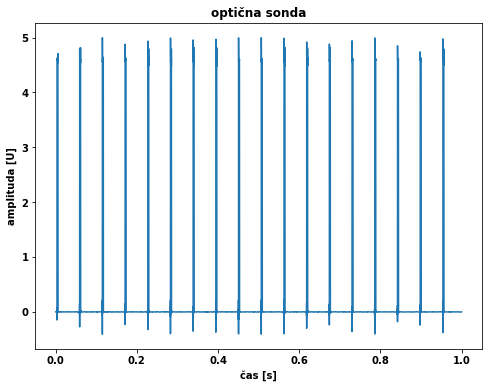

In [10]:
#Prikaz podatkov optične sonde
plt.figure(figsize=(8,6))
plt.plot(t,Tacho_Z)
plt.xlabel('čas [s]');
plt.ylabel('amplituda [U]');
plt.title('optična sonda');

Preštejemo število ciklov narejenih v eni sekundi:

In [11]:
from scipy.signal import find_peaks

min_visina = 4

peaks_z, _ = find_peaks(Tacho_Z, height=min_visina, distance = 100)

N_z = len(peaks_z)
N_z

18

In [12]:
#Izračun vrtilne frekvence rotorja
FR = []
for i in range(N_z-1):
    fr = 1/(t[peaks_z[i+1]]-t[peaks_z[i]])
    FR.append(fr)
frek_z = np.mean(FR)
frek_z

17.917626645995547

In [13]:
# V obrate/min:
w = frek_z*60
w

1075.0575987597329

### Prikaz surovih podatkov pospeškomerov

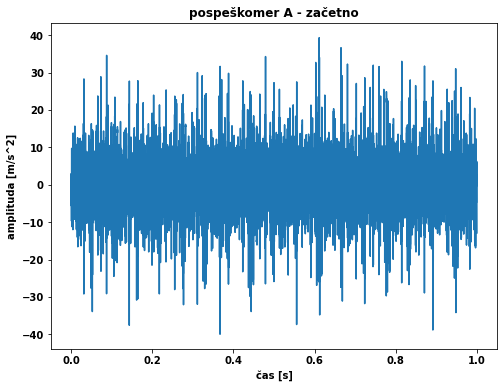

In [14]:
# POSPEŠEK ležaja A
plt.figure(figsize=(8,6))
plt.plot(t,aA)
plt.xlabel('čas [s]');
plt.ylabel('amplituda [m/s^2]');
plt.title('pospeškomer A - začetno');

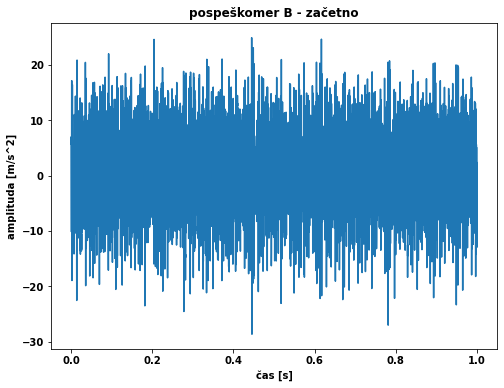

In [87]:
# POSPEŠEK ležaja A
plt.figure(figsize=(8,6))
plt.plot(t,aB)
plt.xlabel('čas [s]');
plt.ylabel('amplituda [m/s^2]');
plt.title('pospeškomer B - začetno');

Surovi podatki imajo veliko šuma, česar ne želimo, saj je takšen signal neuporaben, zato ga bomo filtrirali. Uporabili bomo ozkopasoven filter, ki prepušča le v območju, kjer je vrtilna frekvenca rotorja:

In [16]:
dt = 1/len(Tacho)
freq = np.fft.rfftfreq(len(t), dt)
fs = len(Tacho) # Frekvenca vzorčenja
N_z = 5         # Red filtra
Wn = [16,20]    # Pas filtriranja
sos = signal.butter(N_z, Wn, btype='bandpass', output='sos', analog=False, fs=fs)
w, h = signal.sosfreqz(sos, freq, whole=False, fs=fs)

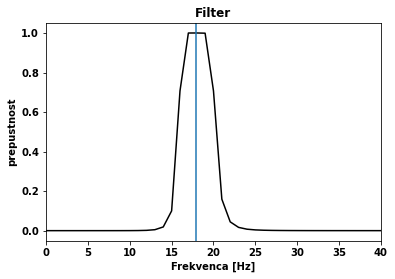

In [17]:
# Oblika filtra
fig, ax = plt.subplots()
plt.plot(freq, np.abs(h), c='k')
plt.axvline(frek_z)
plt.xlim(0,40);
plt.xlabel('Frekvenca [Hz]');
plt.ylabel('prepustnost');
plt.title('Filter');

In [18]:
# Filtriranje podatkov obeh pospeškomerov
azf = signal.sosfilt(sos,aA)
bzf = signal.sosfilt(sos,aB)

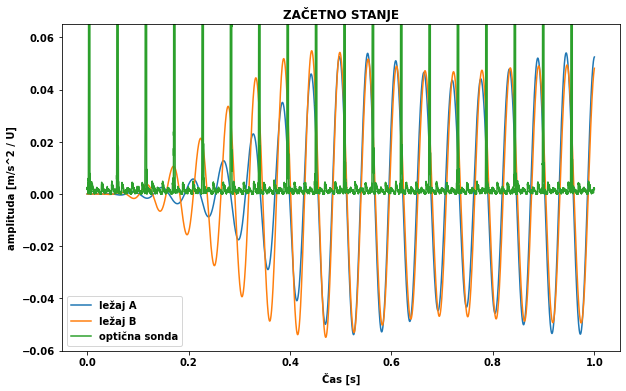

In [19]:
plt.figure(figsize=(10,6))
plt.plot(t,azf,label='ležaj A')
plt.plot(t,bzf,label='ležaj B')
plt.plot(t,np.abs(Tacho_Z),label='optična sonda')
plt.legend();
plt.xlabel('Čas [s]')
plt.ylabel('amplituda [m/s^2 / U]')
plt.title('ZAČETNO STANJE')
plt.ylim(-0.06,0.065);

Sedaj lahko vidimo bolšje podatke iz pospeškomerov, vendar je način filtriranja podatke tudi nekoliko pokvaril, kar vidimo na začetku signala, ki izgleda kot zagon sistema. Vemo pa, da meritve ne izvajamo med zagonom, zato so tudi ti podatki neprimerni za izračun. Zaradi tega bomo filtrirali v frekvenčni domeni, kot je to predstavljeno spodaj

In [20]:
#LEŽAJ A
fft_az = np.fft.rfft(aA)*2/len(Tacho) #Fourierova transformacija
fft_afz = fft_az * np.abs(h) #Filtiranje v frekvenčni domeni

#LEŽAJ B
fft_bz = np.fft.rfft(aB)*2/len(Tacho)
fft_bfz = fft_bz * np.abs(h)

In [21]:
# Prehod iz frekvenčne domene nazaj v časovno domeno za prikaz filtriranih podatkov
aAz = np.fft.irfft(fft_afz)*(len(Tacho)/2)
aBz = np.fft.irfft(fft_bfz)*(len(Tacho)/2)

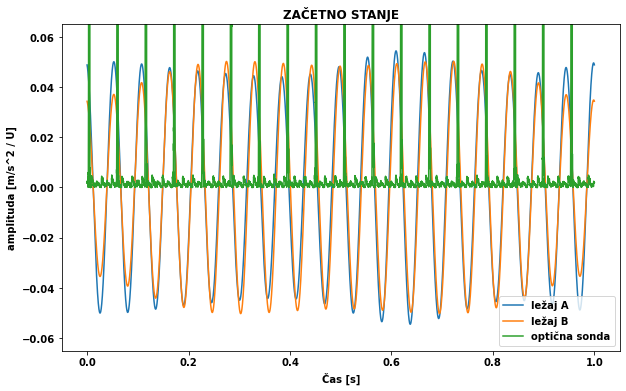

In [90]:
plt.figure(figsize=(10,6))
plt.plot(t,aAz,label='ležaj A')
plt.plot(t,aBz,label='ležaj B')
plt.plot(t,np.abs(Tacho_Z),label='optična sonda')
plt.legend();
plt.xlabel('Čas [s]')
plt.ylabel('amplituda [m/s^2 / U]')
plt.title('ZAČETNO STANJE')
plt.ylim(-0.065,0.065);

Sedaj imamo podatke, ki so primerni za uporabo pri računanju mase debalansa in pozicije korekcijske mase

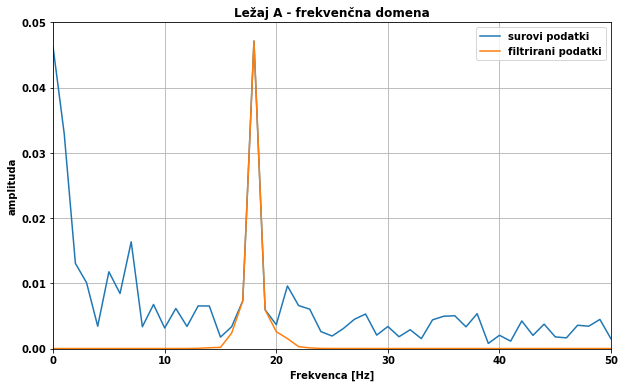

In [23]:
# Prikaz podatkov ležaja A v frekvenčni domeni
plt.figure(figsize=(10,6))
plt.plot(freq,np.abs(fft_az),label='surovi podatki')
plt.plot(freq,np.abs(fft_afz),label='filtrirani podatki')
plt.title('Ležaj A - frekvenčna domena')
plt.legend();
plt.grid();
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('amplituda')
plt.xlim(0,50);
plt.ylim(0,0.05);

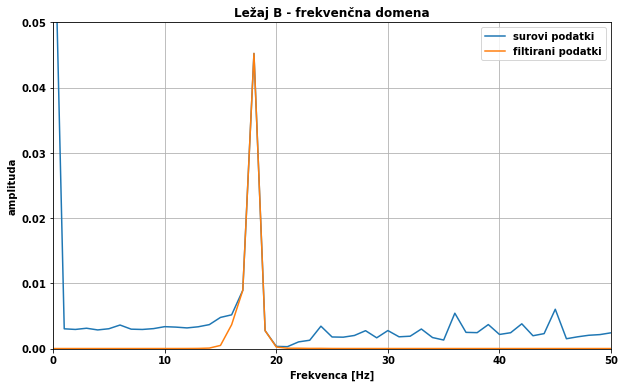

In [24]:
# Prikaz podatkov ležaja A v frekvenčni domeni
plt.figure(figsize=(10,6))
plt.plot(freq,np.abs(fft_bz),label='surovi podatki')
plt.plot(freq,np.abs(fft_bfz),label='filtirani podatki')
plt.title('Ležaj B - frekvenčna domena')
plt.legend();
plt.grid();
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('amplituda')
plt.xlim(0,50);
plt.ylim(0,0.05);

Izračun amplitude pospeškov začetnega stanja

In [92]:
A_uA = 1000*np.max(np.abs(fft_afz))
A_uB = 1000*np.max(np.abs(fft_bfz))
print(f"A_uA = {A_uA.round(2)} mm/s\u00B2")
print(f"A_uB = {A_uB.round(2)} mm/s\u00B2")

A_uA = 47.14 mm/s²
A_uB = 45.24 mm/s²


## Testna masa

In [26]:
len(Tacho)

25600

In [27]:
dt=3.90625e-05
t=dt*len(aBt)
t

1.0

Podatki izmerjeni s testno maso imajo enako število podatkov in enako dolg čas signala

In [28]:
t=np.linspace(0,1,len(Tacho))

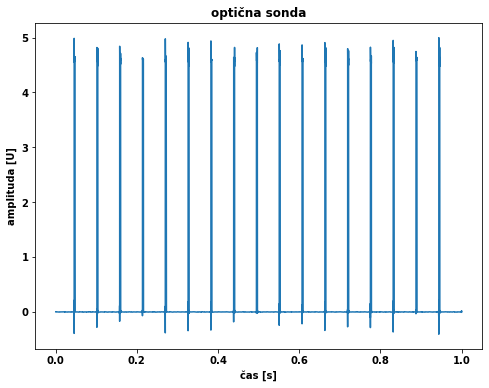

In [29]:
#Prikaz podatkov optične sonde
plt.figure(figsize=(8,6))
plt.plot(t,Tacho)
plt.xlabel('čas [s]');
plt.ylabel('amplituda [U]');
plt.title('optična sonda');

Postopek izračuna vrtilne frekvence ponovimo tako kot prej

In [30]:
from scipy.signal import find_peaks

min_visina = 4

peaks, _ = find_peaks(Tacho, height=min_visina, distance = 100)

N_t = len(peaks)

In [31]:
N_t

17

In [32]:
FR = []
for i in range(N_t-1):
    fr = 1/(t[peaks[i+1]]-t[peaks[i]])
    FR.append(fr)

In [33]:
frek = np.mean(FR)
frek

17.808847691836814

In [34]:
# V obrate/min:
w = frek*60
w

1068.5308615102088

### Prikaz surovih podatkov pospeškomerov

Izrišimo in pripravimo podatke še za testno stanje pospeškomerov:

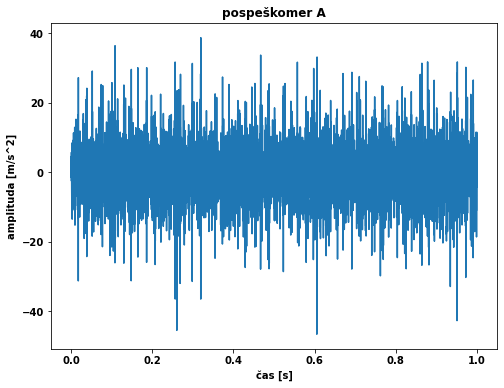

In [35]:
# POSPEŠEK ležaja A
plt.figure(figsize=(8,6))
plt.plot(t,aAt)
plt.xlabel('čas [s]');
plt.ylabel('amplituda [m/s^2]');
plt.title('pospeškomer A');

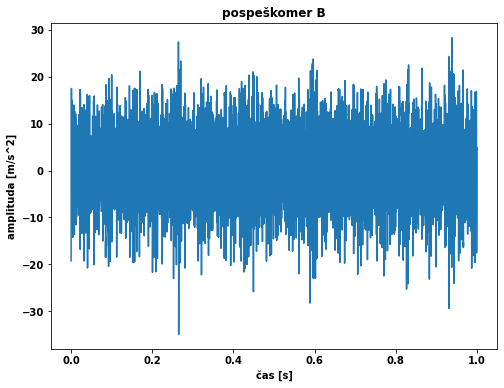

In [36]:
# POSPEŠEK ležaja A
plt.figure(figsize=(8,6))
plt.plot(t,aBt)
plt.xlabel('čas [s]');
plt.ylabel('amplituda [m/s^2]');
plt.title('pospeškomer B');

Signale filtriramo na enak način kot za začetno stanje:

In [37]:
dt = 1/len(Tacho)
dt

3.90625e-05

In [38]:
freq = np.fft.rfftfreq(len(t), dt)
fs = len(Tacho) # Frekvenca vzorčenja
N_f = 5         # Red filtra
Wn = [16,20]    # Območje filtra
sos = signal.butter(N_f, Wn, btype='bandpass', output='sos', analog=False, fs=fs)
w, h = signal.sosfreqz(sos, freq, whole=False, fs=fs)

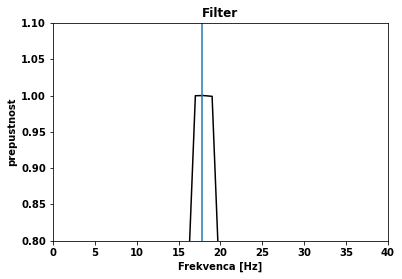

In [39]:
fig, ax = plt.subplots()
plt.plot(freq, np.abs(h), c='k')
plt.axvline(frek)
plt.xlabel('Frekvenca [Hz]');
plt.ylabel('prepustnost');
plt.title('Filter');
plt.xlim(0,40);
plt.ylim(0.8,1.1);

In [40]:
# Filtrirani podatki
af = signal.sosfilt(sos,aAt)
bf = signal.sosfilt(sos,aBt)

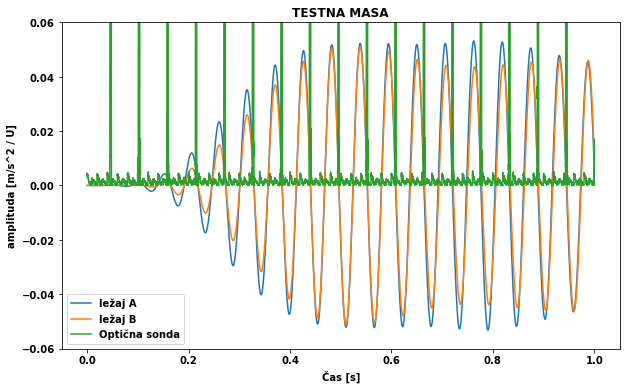

In [41]:
# Časovno filtrirani podatki
plt.figure(figsize=(10,6))
plt.plot(t,af,label='ležaj A')
plt.plot(t,bf,label='ležaj B')
plt.plot(t,np.abs(Tacho),label='Optična sonda')
plt.legend();
plt.title('TESTNA MASA');
plt.ylim(-0.06,0.06);
plt.xlabel('Čas [s]');
plt.ylabel('amplituda [m/s^2 / U]');

In [42]:
# LEŽAJ A
fft_at = np.fft.rfft(aAt)*2/len(Tacho) # Fourierova transformacija
fft_aft = fft_at * np.abs(h) # Filtriranje 

# LEŽAJ B
fft_bt = np.fft.rfft(aBt)*2/len(Tacho)
fft_bft = fft_bt * np.abs(h)

In [43]:
# Prehod nazaj v časovno domeno
aAt = np.fft.irfft(fft_aft)*(len(Tacho)/2)
aBt = np.fft.irfft(fft_bft)*(len(Tacho)/2)

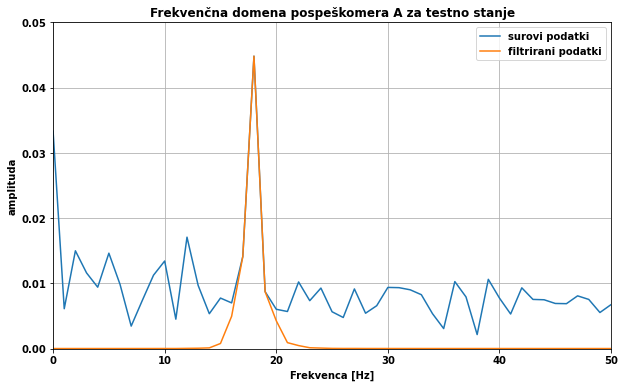

In [44]:
# Frekvenčna domena podatkov ležaja A
plt.figure(figsize=(10,6))
plt.plot(freq,np.abs(fft_at),label='surovi podatki')
plt.plot(freq,np.abs(fft_aft),label='filtrirani podatki')
plt.legend();
plt.grid();
plt.title('Frekvenčna domena pospeškomera A za testno stanje')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('amplituda')
plt.xlim(0,50);
plt.ylim(0,0.05);

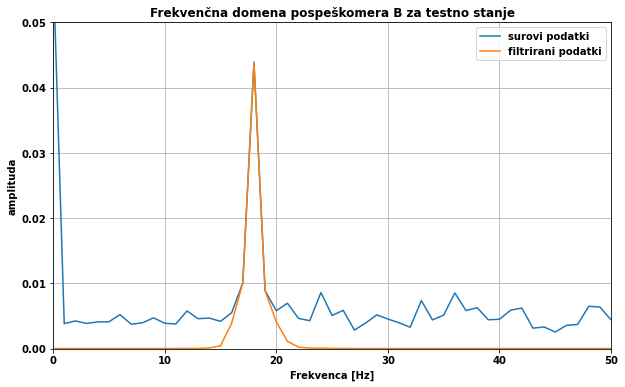

In [45]:
# Frekvenčna domena podatkov ležaja B
plt.figure(figsize=(10,6))
plt.plot(freq,np.abs(fft_bt),label='surovi podatki')
plt.plot(freq,np.abs(fft_bft),label='filtrirani podatki')
plt.legend();
plt.grid();
plt.title('Frekvenčna domena pospeškomera B za testno stanje')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('amplituda')
plt.xlim(0,50);
plt.ylim(0,0.05);

In [46]:
# Izračun amplitude pospeška s testno maso
A_uwA = 1000*np.max(np.abs(fft_aft))
A_uwB = 1000*np.max(np.abs(fft_bft))
print(f"A_uwA = {A_uwA:.2f} mm/s\u00B2")
print(f"A_uwB = {A_uwB:.2f} mm/s\u00B2")

A_uwA = 44.82 mm/s²
A_uwB = 43.89 mm/s²


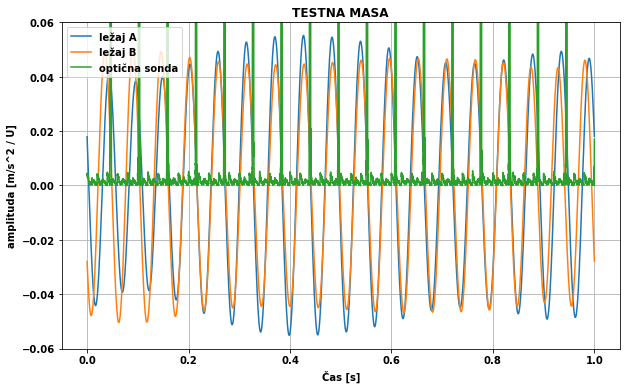

In [47]:
# Prikaz filtriranih podatkov

plt.figure(figsize=(10,6))
plt.plot(t,aAt,label='ležaj A')
plt.plot(t,aBt,label='ležaj B')
plt.plot(t,np.abs(Tacho),label='optična sonda')
plt.legend();
plt.grid();
plt.xlabel('Čas [s]')
plt.ylabel('amplituda [m/s^2 / U]')
plt.title('TESTNA MASA')
plt.ylim(-0.06,0.06);

## Določitev kotov in izračun mase debalansa

Določiti moramo vrhove pospeška, saj bomo tako dobili točke, iz katerih lahko izračunamo kot med optično sondo in pospeškomerom

In [48]:
# Določitev vrhov za LEŽAJ A - testno stanje
min_visina = 0.025

lezaj_A_peaks, _ = find_peaks(aAt, height=min_visina, distance = 200)

N_A = len(lezaj_A_peaks)

In [49]:
N_A

18

In [50]:
# Določitev vrhov za LEŽAJ B - testno stanje
min_visina = 0.025

lezaj_B_peaks, _ = find_peaks(aBt, height=min_visina, distance = 200)

N_B = len(lezaj_B_peaks)

In [51]:
N_B

18

In [52]:
lezaj_A_peaks

array([ 1107,  2452,  3808,  5195,  6607,  8038,  9478, 10919, 12361,
       13797, 15227, 16658, 18100, 19556, 21023, 22488, 23930, 25339],
      dtype=int64)

In [53]:
lezaj_B_peaks

array([  900,  2305,  3735,  5182,  6633,  8078,  9517, 10952, 12386,
       13825, 15266, 16711, 18157, 19594, 21011, 22402, 23766, 25123],
      dtype=int64)

In [54]:
# vrhovi optične sonde - testno stanje
peaks

array([ 1162,  2597,  4033,  5472,  6911,  8350,  9788, 11279, 12715,
       14098, 15538, 16977, 18414, 19850, 21286, 22725, 24165],
      dtype=int64)

In [55]:
len(peaks)

17

Določitev vrhov za začetno stanje

In [56]:
# Določitev vrhov za LEŽAJ A - začetno stanje
min_visina = 0.03

lezaj_Az_peaks, _ = find_peaks(aAz, height=min_visina, distance = 100)

N_Az = len(lezaj_Az_peaks)

In [57]:
N_Az

18

In [58]:
# Določitev vrhov za LEŽAJ B - začetno stanje
min_visina = 0.025

lezaj_Bz_peaks, _ = find_peaks(aBz, height=min_visina, distance = 100)

N_Bz = len(lezaj_Bz_peaks)

In [59]:
N_Bz

18

In [60]:
# Vrhovi optične sonde - začetno stanje
N_laserZ = peaks_z

In [61]:
print(len(N_laserZ))
N_laserZ

18


array([  134,  1564,  2942,  4376,  5808,  7239,  8668, 10099, 11532,
       12966, 14399, 15830, 17260, 18691, 20125, 21560, 22992, 24424],
      dtype=int64)

In [62]:
print(len(lezaj_Az_peaks))
lezaj_Az_peaks

18


array([ 1350,  2753,  4167,  5581,  6990,  8403,  9829, 11269, 12713,
       14155, 15591, 17024, 18463, 19907, 21347, 22770, 24172, 25560],
      dtype=int64)

In [63]:
print(len(lezaj_Bz_peaks))
lezaj_Bz_peaks

18


array([ 1349,  2751,  4170,  5600,  7034,  8469,  9903, 11335, 12766,
       14198, 15631, 17065, 18501, 19935, 21363, 22780, 24178, 25563],
      dtype=int64)

In [64]:
# Določimo katere vrhove bomo upoštevali pri nadaljnem računanju
N_laserZ = N_laserZ#[1:]
lezaj_Az_peaks = lezaj_Az_peaks#[:-1]
lezaj_Bz_peaks = lezaj_Bz_peaks#[:-1]

### Začetno stanje kot velik FI

Izračunamo kot med optično sondo in pospeški ležajev za začetno stanje

In [65]:
# Kot med optično sondo in lažajem A
fi_zA = []
for i in range(len(N_laserZ)):
    delta_zA =  N_laserZ[i] - lezaj_Az_peaks[i]
    fi_zA.append(((delta_zA*dt)*360))

In [66]:
# Povprečna vrednost kota
np.mean(fi_zA)

-16.74609375

In [67]:
# Kot med optično sondo in ležajem B
fi_zB = []
for i in range(len(N_laserZ)):
    delta_zB =  N_laserZ[i] - lezaj_Bz_peaks[i]
    fi_zB.append(((delta_zB*dt)*360))

In [68]:
# Povprečna vrednost kota
np.mean(fi_zB)

-17.173437500000002

### Testno stanje kot velik FI

Določitev vrhov za testno stanje

In [69]:
print(len(peaks))
peaks

17


array([ 1162,  2597,  4033,  5472,  6911,  8350,  9788, 11279, 12715,
       14098, 15538, 16977, 18414, 19850, 21286, 22725, 24165],
      dtype=int64)

In [70]:
print(len(lezaj_B_peaks))
lezaj_B_peaks#[:-1]

18


array([  900,  2305,  3735,  5182,  6633,  8078,  9517, 10952, 12386,
       13825, 15266, 16711, 18157, 19594, 21011, 22402, 23766, 25123],
      dtype=int64)

In [71]:
print(len(lezaj_A_peaks))
lezaj_A_peaks#[:-1]

18


array([ 1107,  2452,  3808,  5195,  6607,  8038,  9478, 10919, 12361,
       13797, 15227, 16658, 18100, 19556, 21023, 22488, 23930, 25339],
      dtype=int64)

In [72]:
# Izberemo katere vrhove bomo uporabili v nadaljnem računanju
N_laserT = peaks[:-1]
lezaj_A_peaks = lezaj_A_peaks#[:-1]
lezaj_B_peaks = lezaj_B_peaks#[:-1]

In [73]:
# Kot med optično sondo in ležajem A 
fi_tA = []
for i in range(len(N_laserT)):
    delta_tA =  N_laserT[i] - lezaj_A_peaks[i]
    fi_tA.append(((delta_tA*dt)*360))

In [74]:
# Povprečna vrednost kota
np.mean(fi_tA)

3.8504882812500005

In [75]:
# Kot med optično sondo in ležajem B 
fi_tB = []
for i in range(len(N_laserT)):
    delta_tB =  N_laserT[i] - lezaj_B_peaks[i]
    fi_tB.append(((delta_tB*dt)*360))

In [76]:
# Povprečna vrednost kota
np.mean(fi_tB)

3.9911132812500005

### Izračun razlike kotov med testnim in začetnim stanjem

In [77]:
# Razlika kotov za ležaj A
fi_a = np.mean(fi_tA) - np.mean(fi_zA)

In [78]:
# Razlika kotov za ležaj B
fi_b = np.mean(fi_tB) - np.mean(fi_zB)

Prikaz vseh do sedaj izačunanih rezultatov 

In [79]:
print('\nzačetno stanje\n')
print(f"A_uA = {A_uA:.2f} mm/s\u00B2")
print(f"A_uB = {A_uB:.2f} mm/s\u00B2")
print('------------------')
print('\ntestno stanje\n')
print(f"A_uwA = {A_uwA:.2f} mm/s\u00B2")
print(f"A_uwB = {A_uwB:.2f} mm/s\u00B2")
print('------------------')
print('\nrazlika kotov\n')
print(f"fi_a = {fi_a:.2f}°")
print(f"fi_b = {fi_b:.2f}°")


začetno stanje

A_uA = 47.14 mm/s²
A_uB = 45.24 mm/s²
------------------

testno stanje

A_uwA = 44.82 mm/s²
A_uwB = 43.89 mm/s²
------------------

razlika kotov

fi_a = 20.60°
fi_b = 21.16°


Imamo vse potrebne podatke za izračun preostalih neznank, ki so kot alfa, Aw_a/b in masa debalansa 

In [80]:
# Testna masa
mt = 2.8 #g

In [81]:
# Izračun tretje komponente polja hitrosti za ležaj A in B
AwA = np.sqrt(A_uA**2 + A_uwA**2 - 2*A_uA*A_uwA*np.cos(np.deg2rad(fi_a)))
AwB = np.sqrt(A_uB**2 + A_uwB**2 - 2*A_uB*A_uwB*np.cos(np.deg2rad(fi_b)))

In [82]:
print(f"AwA = {AwA:.2f} mm/s\u00B2")
print(f"AwB = {AwB:.2f} mm/s\u00B2")

AwA = 16.60 mm/s²
AwB = 16.42 mm/s²


In [83]:
# Izračun mase debalansa za podatke iz ležaja A in ležaja B
m0_A = (A_uA/AwA)*mt
m0_B = (A_uB/AwB)*mt

In [84]:
print(f"m0_A = {m0_A:.2f} g")
print(f"m0_B = {m0_B:.2f} g")

m0_A = 7.95 g
m0_B = 7.71 g


Razlika v masi debalansa dobljeni iz ležaja A ali ležaja B je posledica same meritve in nelinearnosti celotnega sistema. Dobili smo zelo podobne rezultate

Izračunamo še kot na katerega bomo glede na testno maso v smeri vrtenja namestili korekcijsko maso, ki je enaka masi debalansa:

In [85]:
alfa_A = np.degrees(np.arccos((A_uA**2 + AwA**2 - A_uwA**2)/(2*A_uA*AwA)))
alfa_B = np.degrees(np.arccos((A_uB**2 + AwB**2 - A_uwB**2)/(2*A_uB*AwB)))

In [86]:
print(f"alfa_A = {alfa_A:.2f}°")
print(f"alfa_B = {alfa_B:.2f}°")

alfa_A = 71.80°
alfa_B = 74.80°
